# Modello gerarchico beta-binomiale con Stan {#sec-stan-hier_beta_binom}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
import logging
import os
import warnings
from io import StringIO
import requests
warnings.simplefilter(action='ignore', category=FutureWarning)
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [14]:
seed: int = sum(map(ord, "stan_hier_beta_binomial"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduzione {.unnumbered}

Nel capitolo precedente, abbiamo esplorato un modello gerarchico focalizzato sulla marginalizzazione dei parametri di disturbo. In questo nuovo capitolo, introduciamo una variante del modello gerarchico, applicata a un contesto in cui osserviamo il numero di successi ottenuti da ciascun partecipante su un numero fisso di prove. In questo caso, trattiamo la probabilità di successo di ciascun partecipante come una variabile incerta che vogliamo inferire.

Sebbene entrambi i modelli adottino un approccio gerarchico per gestire la variabilità individuale, si distinguono per i parametri di interesse e il modo in cui affrontano questa variabilità. Nel modello precedente, l'attenzione era rivolta alla stima di una differenza media di gruppo, marginalizzando esplicitamente i parametri individuali. Il modello attuale, invece, è orientato principalmente a stimare le probabilità di successo individuali, consentendo l'inferenza bayesiana in un contesto diverso, con obiettivi specifici.

## Motivazione per i Modelli Gerarchici Bayesiani

I modelli gerarchici bayesiani sono potenti strumenti per stimare parametri individuali basandosi su dati raccolti da un campione di partecipanti. In un mondo ideale, potremmo osservare direttamente i parametri di interesse, ma nella realtà dobbiamo inferirli dalle scelte o risposte dei partecipanti. Se disponiamo di un modello probabilistico che collega i parametri ai dati osservati e forniamo una distribuzione a priori ragionevole per tali parametri, possiamo usare l'inferenza bayesiana per apprendere su di essi.

Un aspetto fondamentale dei modelli gerarchici è che, avendo dati da più partecipanti, possiamo sfruttare questa informazione condivisa per migliorare le stime dei parametri di ciascun individuo. Questo è particolarmente utile negli esperimenti psicologici, dove si presume che i partecipanti appartengano a una popolazione omogenea e che i loro parametri siano estratti dalla stessa distribuzione.

### Inferenza sui Parametri a Livello di Popolazione

Un aspetto chiave dei modelli gerarchici è l'inferenza sui parametri a livello di popolazione. Ogni partecipante fornisce informazioni non solo sul proprio parametro, ma anche sui parametri che governano la distribuzione dell'intera popolazione. Conoscere questi parametri di livello superiore ci consente di migliorare la stima dei parametri individuali, in quanto agiscono come distribuzioni a priori per ogni partecipante. Inoltre, la conoscenza dei parametri a livello di popolazione è spesso di maggiore interesse per i ricercatori, in quanto consente di fare affermazioni che si estendono oltre il campione osservato e riguardano la popolazione generale.

### Struttura Gerarchica dei Dati

Per illustrare l'uso dei modelli gerarchici, consideriamo uno studio sulla "terapia tattile", una pratica infermieristica controversa [@doing_bayesian_data_an]. L'esperimento, condotto da @rosa1998close, mirava a testare la capacità degli operatori di percepire "campi energetici" senza contatto visivo. Gli operatori dovevano identificare quale delle loro mani era stata "selezionata" da un esaminatore, senza poter vedere, in 10 prove per operatore, con risposte classificate come "corrette" o "errate".

In questo contesto, la struttura gerarchica emerge naturalmente. Al livello più basso, abbiamo le singole prove di ciascun operatore. Queste prove sono raggruppate per operatore, formando il secondo livello della gerarchia. Infine, tutti gli operatori appartengono alla popolazione generale di praticanti di terapia tattile, rappresentando il livello più alto della gerarchia.

Questa struttura ci permette di stimare non solo le abilità individuali degli operatori, ma anche i parametri che descrivono la distribuzione delle abilità nella popolazione complessiva. Possiamo così quantificare l'eterogeneità tra gli operatori e valutare se le loro prestazioni superano ciò che ci aspetteremmo dal caso. L'approccio gerarchico bayesiano diventa un potente strumento per comprendere la variabilità nei dati e migliorare la nostra capacità di fare inferenze sia a livello individuale che di popolazione.

## Modelli Gerarchici Bayesiani: Una Panoramica Tecnica

Nei modelli gerarchici bayesiani (BHM), non specifichiamo direttamente la distribuzione a priori dei parametri individuali. Invece, facciamo dipendere questa distribuzione da altri parametri, chiamati iperparametri. Questo approccio riflette una gerarchia di inferenza: inferiamo prima i parametri a livello di popolazione, e poi usiamo queste informazioni per inferire i parametri individuali.

Ad esempio, in un modello non-gerarchico, potremmo specificare una distribuzione a priori completamente definita per ogni parametro individuale (ad es., una Gaussiana univariata per ciascun parametro). Nei modelli gerarchici, invece, la distribuzione dei parametri individuali dipende da iperparametri che descrivono la distribuzione a livello di popolazione.

La formulazione di questi modelli può essere scritta come:

- Verosimiglianza: $p(y \mid \theta)$
- Prior: $p(\theta \mid \xi)$
- Iperprior: $p(\xi)$

Dunque, la differenza chiave è che la distribuzione a priori dei parametri individuali dipende da una distribuzione superiore, introdotta dagli iperparametri, creando così un sistema di inferenza a più livelli. Questo processo, sebbene concettualmente non nuovo, consente un'inferenza più precisa, poiché sfrutta le informazioni a livello di popolazione per migliorare la stima dei parametri individuali.

In sintesi, i modelli gerarchici bayesiani rappresentano un approccio flessibile e potente per affrontare problemi inferenziali complessi, particolarmente utili quando si vuole modellare la variabilità tra soggetti in modo rigoroso e coerente.

## Analisi Bayesiana della "Terapia Tattile"

Lo studio condotto da @rosa1998close ha coinvolto un campione di 28 operatori. L'obiettivo della ricerca è valutare la proporzione di risposte corrette per ciascun operatore e confrontarla con una proporzione attesa di 0.50, che rappresenta l'ipotesi nulla di performance casuale. L'analisi principale mira a determinare se, complessivamente, il gruppo di operatori mostra una prestazione statisticamente superiore a quella attesa in base al puro caso. Inoltre, verranno esplorate le differenze individuali tra gli operatori.

Per iniziare, importeremo i dati forniti da @doing_bayesian_data_an.

In [3]:
# Define the URL of the CSV file on GitHub
url = "https://raw.githubusercontent.com/boboppie/kruschke-doing_bayesian_data_analysis/master/2e/TherapeuticTouchData.csv"
# Download the content of the CSV file
response = requests.get(url)
tt_dat = pd.read_csv(StringIO(response.text))
print(tt_dat.head())

   y    s
0  1  S01
1  0  S01
2  0  S01
3  0  S01
4  0  S01


In [4]:
tt_dat.shape

(280, 2)

Nella colonna `y`, il valore 1 indica una risposta corretta, mentre 0 indica una risposta errata. La seconda colonna contiene il codice identificativo di ciascun operatore.

Calcoliamo la proporzione di risposte corrette per ciascun operatore.

In [5]:
tt_agg = tt_dat.groupby("s").agg(proportion_correct=("y", "mean")).reset_index()
print(tt_agg)

,s,proportion_correct
0,S01,0.1
1,S02,0.2
2,S03,0.3
3,S04,0.3
4,S05,0.3
5,S06,0.3
6,S07,0.3
7,S08,0.3
8,S09,0.3
9,S10,0.3


Costruiamo un modello gerarchico partendo dall'ipotesi che il numero di risposte corrette di ciascun operatore sia modellato da una variabile casuale binomiale. Per ciascuno dei ventotto operatori, possiamo esprimere questo come segue:

$$
y_i \sim \text{Binomial}(n_i, p_i),
$$

dove $i = 0, \dots, 27$.

Per modellare la distribuzione a priori del parametro sconosciuto $p_i$, possiamo utilizzare una distribuzione Beta con parametri $a$ e $b$ -- si veda {cite:t}`doingbayesian`:

$$
p_i \sim \text{Beta}(a, b).
$$

È importante notare che gli iperparametri $a$ e $b$ sono condivisi tra tutti gli operatori, caratteristica che definisce un modello gerarchico.

Se $a$ e $b$ sono noti, la distribuzione a posteriori del parametro $p$ per ciascun operatore, dati i risultati osservati $y_i$, è anch'essa una distribuzione Beta:

$$
p_i \mid y_i \sim \text{Beta}(a + y_i, b + n_i - y_i). 
$$

Nel caso più generale, dove gli iperparametri $a$ e $b$ sono incogniti, è necessario stabilire una distribuzione a priori anche per questi. Nell'esempio seguente, useremo i seguenti prior:

$$
a \sim \text{Gamma}(8, 12)\\ 
b \sim \text{Gamma}(27, 5)
$$

Per applicare il modello gerarchico descritto sopra ai dati del *therapeutic touch*, iniziamo a calcolare il numero di risposte corrette di ciascun operatore.

In [6]:
result = tt_dat.groupby("s")["y"].sum().reset_index()
y = result["y"]
print(y)

0     1
1     2
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    4
11    4
12    4
13    4
14    4
15    5
16    5
17    5
18    5
19    5
20    5
21    5
22    6
23    6
24    7
25    7
26    7
27    8
Name: y, dtype: int64


Creiamo il vettore `N` che fornisce il numero di prove per ciascun operatore.

In [7]:
N = tt_dat.groupby("s")["y"].count()

Esaminiamo dunque i dati a disposizione.

In [8]:
print(*N)

10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10


In [9]:
print(y)

0     1
1     2
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    4
11    4
12    4
13    4
14    4
15    5
16    5
17    5
18    5
19    5
20    5
21    5
22    6
23    6
24    7
25    7
26    7
27    8
Name: y, dtype: int64


Creaiamo un dizionario con i dati necessari per Stan.

In [10]:
data = {
    "N": 28,
    "y": y.tolist(),
    "n_trials": N.tolist()
}

print(data)

{'N': 28, 'y': [1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8], 'n_trials': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]}


## Modello Stan

Leggiamo il codice Stan che implementa il modello gerarchico.

In [17]:
stan_file = os.path.join(project_directory, "stan", "h_beta_binom_model.stan")

with open(stan_file, "r") as f:
    print(f.read())

data {
  int<lower=0> N;  // Number of participants
  array[N] int<lower=0> y;  // Number of successes for each participant
  array[N] int<lower=0> n_trials;  // Number of trials for each participant
}

parameters {
  real<lower=0> alpha;  // Alpha parameter for the Beta distribution
  real<lower=0> beta;   // Beta parameter for the Beta distribution
  array[N] real<lower=0, upper=1> p;  // Success probability for each participant
}

model {
  // Priors
  alpha ~ gamma(8, 2);
  beta ~ gamma(27, 5);
  
  // Each participant's success probability follows a Beta distribution
  p ~ beta(alpha, beta);
  
  // Likelihood of the observed data
  for (i in 1:N) {
    y[i] ~ binomial(n_trials[i], p[i]);
  }
}

generated quantities {
  real overall_p = alpha / (alpha + beta);  // Calculate the mean success probability
}



Nel modello:

- `N` è il numero totale di partecipanti
- `y` è un array che contiene il numero di successi per ogni partecipante
- `n_trials` è un array che contiene il numero di prove per ogni partecipante

Il modello è chiamato "gerarchico" perché considera due livelli:

1. Il livello individuale: ogni partecipante ha la propria probabilità di successo
2. Il livello di gruppo: c'è una distribuzione generale che descrive come variano le probabilità di successo tra i partecipanti

- `p`: È un array che contiene la vera probabilità di successo per ogni partecipante. 
- `alpha` e `beta`: Sono i parametri che definiscono la distribuzione Beta, che descrive come variano le probabilità di successo tra i partecipanti.

Impostiamo delle prior per `alpha` e `beta`:

```
alpha ~ gamma(8, 2);
beta ~ gamma(27, 5);
```

Queste prior riflettono le nostre conoscenze o supposizioni iniziali sui possibili valori di questi parametri.

```
p ~ beta(alpha, beta);
```

Questa riga è il cuore del modello gerarchico. Dice che la probabilità di successo di ogni partecipante (`p`) segue una distribuzione Beta, i cui parametri sono `alpha` e `beta`. Questo crea un legame tra tutti i partecipanti: le loro prestazioni individuali sono considerate come variazioni attorno a una tendenza generale del gruppo.

```
for (i in 1:N) {
  y[i] ~ binomial(n_trials[i], p[i]);
}
```

Questa parte del modello descrive come i dati osservati (`y`) sono generati, dato il numero di prove (`n_trials`) e la vera probabilità di successo (`p`) per ogni partecipante.

```
real overall_p = alpha / (alpha + beta);
```

Questa riga calcola la probabilità di successo media per l'intero gruppo.

In conclusione, questo modello ci permette di stimare la probabilità di successo individuale per ogni partecipante, comprendere come queste probabilità variano nel gruppo e ottenere una stima della probabilità di successo media per l'intero gruppo. Il vantaggio principale di questo approccio gerarchico è che combina informazioni a livello individuale e di gruppo, permettendo stime più precise, specialmente per i partecipanti con pochi dati.

## Compilazione e sampling

Compiliamo il modello.

In [18]:
model = CmdStanModel(stan_file=stan_file)

Eseguiamo il campionamento MCMC.

In [19]:
fit = model.sample(
    data=data,
    iter_warmup=2000, 
    iter_sampling=4000,
    seed=84735, 
    chains=4,
    show_progress=False, 
    show_console=False
)

## Esame delle distribuzioni a posteriori

Esaminiamo le stime a posteriori dei parametri.

In [20]:
az.summary(fit, var_names=(["alpha", "beta", "p"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.591,0.866,2.991,6.359,0.008,0.006,10600.0,10141.0,1.0
beta,5.756,0.932,4.009,7.623,0.008,0.006,12032.0,11787.0,1.0
p[0],0.273,0.100,0.091,0.469,0.001,0.000,20279.0,11628.0,1.0
p[1],0.324,0.103,0.129,0.524,0.001,0.001,20614.0,11911.0,1.0
p[2],0.373,0.107,0.174,0.588,0.001,0.001,20791.0,11355.0,1.0
p[3],0.372,0.106,0.179,0.590,0.001,0.001,22416.0,11620.0,1.0
p[4],0.373,0.107,0.173,0.582,0.001,0.001,22260.0,11753.0,1.0
p[5],0.374,0.106,0.173,0.583,0.001,0.001,21443.0,12716.0,1.0
p[6],0.372,0.106,0.172,0.580,0.001,0.001,21992.0,12317.0,1.0
p[7],0.372,0.106,0.173,0.582,0.001,0.001,21133.0,11017.0,1.0


Le distribuzioni posteriori degli iperparametri, prese da sole, non hanno un significato chiaro. Tuttavia, possiamo utilizzarle per calcolare la distribuzione a posteriori della probabilità di una risposta corretta per tutto il gruppo.

Convertiamo l'oggetto `fit` creato da cmdstanpy in un oggetto InferenceData usando ArviZ:

In [21]:
idata = az.from_cmdstanpy(posterior=fit)

## Schrinkage bayesiano

Nel contesto dei modelli gerarchici bayesiani, il fenomeno dello "shrinkage" (contrazione o riduzione) è un aspetto fondamentale e desiderabile, specialmente quando si modellano dati provenienti da gruppi o sotto-popolazioni con campionature di dimensioni diverse o variazioni intrinseche. Questo fenomeno può essere particolarmente rilevante e utile nel tuo modello gerarchico per il numero di risposte corrette di ciascun operatore, modello che utilizza una distribuzione binomiale per le osservazioni e una Beta per i priori dei parametri di successo $p_i$.

Lo "shrinkage" in un modello bayesiano gerarchico si riferisce al processo per cui le stime dei parametri individuali (ad esempio, le probabilità di successo per ciascun operatore nel presente modello) sono "spostate" verso una media di gruppo. Questo accade perché il modello considera sia i dati osservati per ciascun gruppo (o individuo) sia le informazioni aggiuntive fornite dalla struttura gerarchica e dai dati degli altri gruppi.

Nel presente modello:

- ogni operatore ha una probabilità di successo $p_i$ che segue una distribuzione $\text{Beta}(a, b)$, dove $a$ e $b$ sono iperparametri condivisi tra tutti gli operatori;
- gli iperparametri $a$ e $b$ sono stimati dai dati di tutti gli operatori, e quindi forniscono una base comune che riflette le caratteristiche medie di tutti gli operatori.

Se un operatore ha pochi dati (ad esempio, pochi tentativi o risposte), la stima di $p_i$ per quell'operatore sarà fortemente influenzata dai valori di $a$ e $b$, "spostando" la stima di $p_i$ verso la media di gruppo. Questo riduce l'impatto delle fluttuazioni casuali nei dati di quell'operatore, che potrebbero altrimenti portare a stime eccessivamente ottimistiche o pessimistiche.

Lo shrinkage ha i seguenti benefici:

1. **migliore Stima per Gruppi con Pochi Dati.** Operatori con meno dati beneficiano maggiormente dello shrinkage, in quanto le loro stime sono stabilizzate attraverso l'informazione "prestata" dagli altri operatori;
2. **riduzione dell'Overfitting.** Il modello evita di adattarsi troppo ai dati di un singolo operatore, specialmente quando questi sono limitati o rumorosi, risultando in generalizzazioni più robuste;
3. **incorporazione della Struttura dei Dati.** Lo shrinkage riflette l'assunzione che gli operatori siano simili ma non identici, permettendo una certa individualità ma entro un quadro comune che li lega.

Supponiamo che alcuni operatori abbiano mostrato risultati estremamente buoni o cattivi, che potrebbero essere dovuti a varianze casuali. Lo shrinkage modera queste stime estreme, specialmente se non sono supportate da una grande quantità di dati, rendendo le previsioni finali più credibili e meno soggette a errori casuali.

In conclusione, lo shrinkage in un modello gerarchico aiuta a ottenere stime più accurate e credibili per tutti i membri del gruppo, sfruttando le informazioni collettive e limitando l'impatto delle anomalie nei dati individuali.

Per rappresentare visivamente questo fenomeno, iniziamo con il recuperare le stime a posteriori di  `alpha` e `beta`.

In [22]:
alphas = idata.posterior["alpha"]
betas = idata.posterior["beta"]

Creiamo un array che contiene le stime bayesiane della probabilità di successo di ciascun operatore fornite sopra dalla funzione `summary` di ArviZ. Per fare questo usiamo le funzionalità di `xarray`.

In [23]:
# Calcola la media lungo le dimensioni 'chain' e 'draw'
bayesian_estimates = idata.posterior["p"].mean(dim=("chain", "draw"))
print(bayesian_estimates.values)

[0.27273311 0.32377131 0.37344338 0.37214022 0.37257493 0.37351838
 0.37219305 0.37214675 0.37185773 0.37173435 0.42165569 0.42127528
 0.42172633 0.42118034 0.42149943 0.47116033 0.47087155 0.46970487
 0.47107502 0.47138671 0.47205312 0.47221249 0.51906367 0.52052519
 0.57032404 0.57017976 0.56928041 0.62016621]


Generiamo un array con le probabilità empiriche.

In [24]:
# Empirical probabilities
empirical_probs = y.values / N.values
print(empirical_probs)

[0.1 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.6 0.6 0.7 0.7 0.7 0.8]


Il grafico seguente confronta le probabilità empiriche con le stime Bayesiane per la probabilità di successo associata a ciascun operatore. Questa rappresentazione evidenzia il fenomeno di "shrinkage" intrinseco ai modelli Bayesiani gerarchici. In particolare, il grafico illustra come le stime Bayesiane delle probabilità di successo per gli operatori tendono a convergere verso la media generale, in confronto alle probabilità empiriche. 

In [25]:
# Calcola la media generale delle probabilità empiriche
mean_empirical_prob = np.mean(empirical_probs)
mean_empirical_prob

0.43928571428571417

In [26]:
# Calcola la media generale delle stime Bayesiane
mean_bayesian_estimate = np.mean(bayesian_estimates)
mean_bayesian_estimate

<xarray.DataArray 'p' ()> Size: 8B
array(0.44112334)

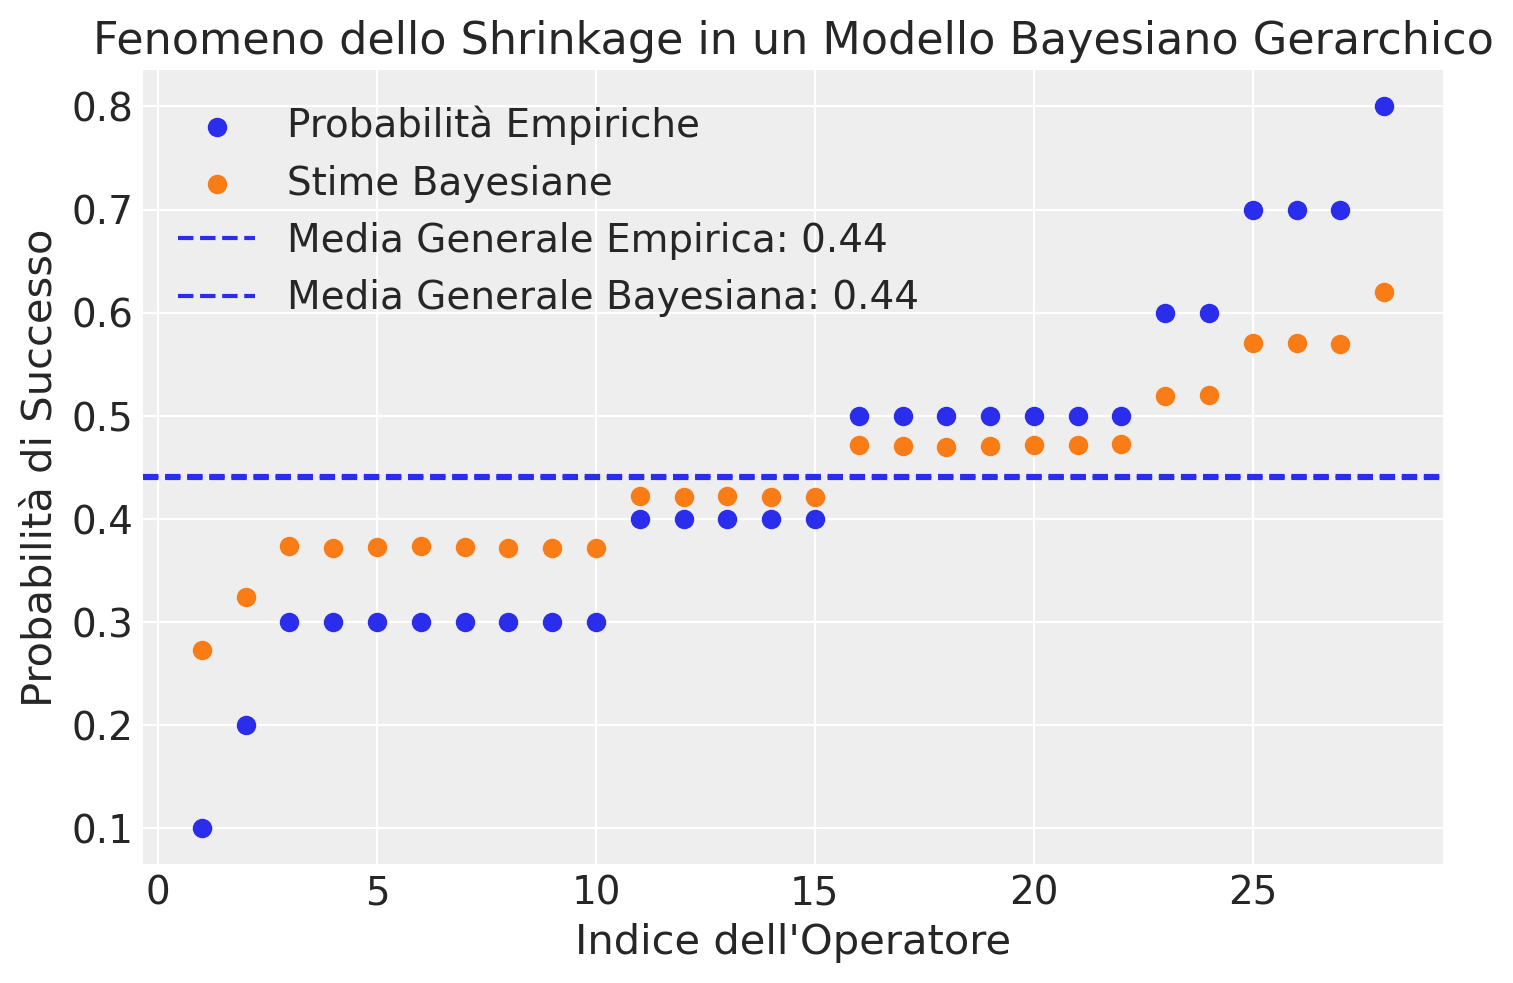

In [27]:
# Crea il grafico
plt.figure()

# Traccia le probabilità empiriche
plt.scatter(range(1, 29), empirical_probs, label="Probabilità Empiriche")

# Traccia le stime Bayesiane
plt.scatter(range(1, 29), bayesian_estimates, color="C1", label="Stime Bayesiane")

# Aggiungi linee orizzontali per indicare le medie generali
plt.axhline(
    y=mean_empirical_prob,
    linestyle="--",
    label=f"Media Generale Empirica: {mean_empirical_prob:.2f}",
)
plt.axhline(
    y=mean_bayesian_estimate,
    linestyle="--",
    label=f"Media Generale Bayesiana: {mean_bayesian_estimate:.2f}",
)

# Etichette e titolo
plt.xlabel("Indice dell'Operatore")
plt.ylabel("Probabilità di Successo")
plt.title("Fenomeno dello Shrinkage in un Modello Bayesiano Gerarchico")
plt.legend()
plt.show()

Esaminiamo la distribuzione a posteriori dei parametri `alpha` e `beta`.

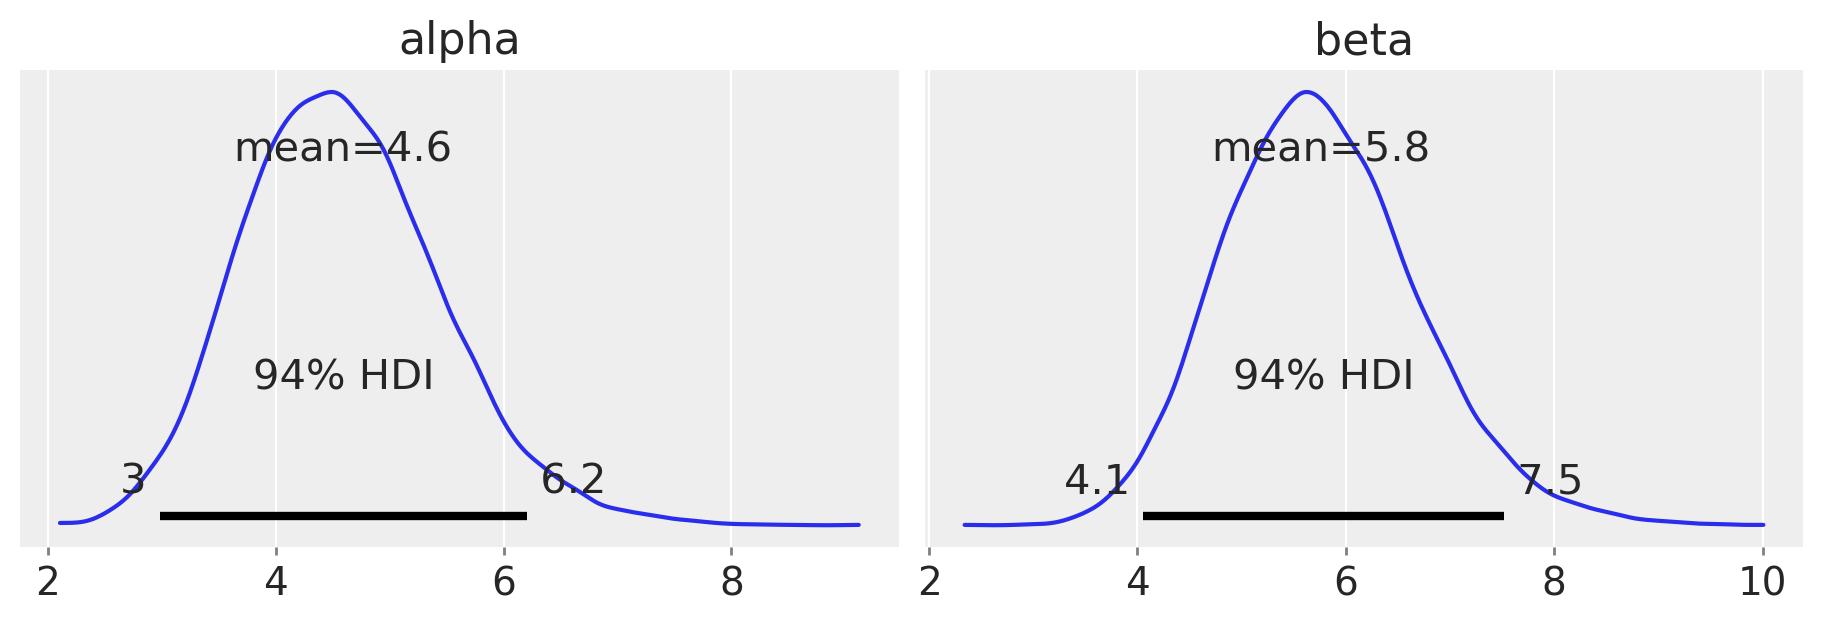

In [28]:
az.plot_posterior(idata, var_names=["alpha", "beta"], figsize=(9, 3))
plt.show()

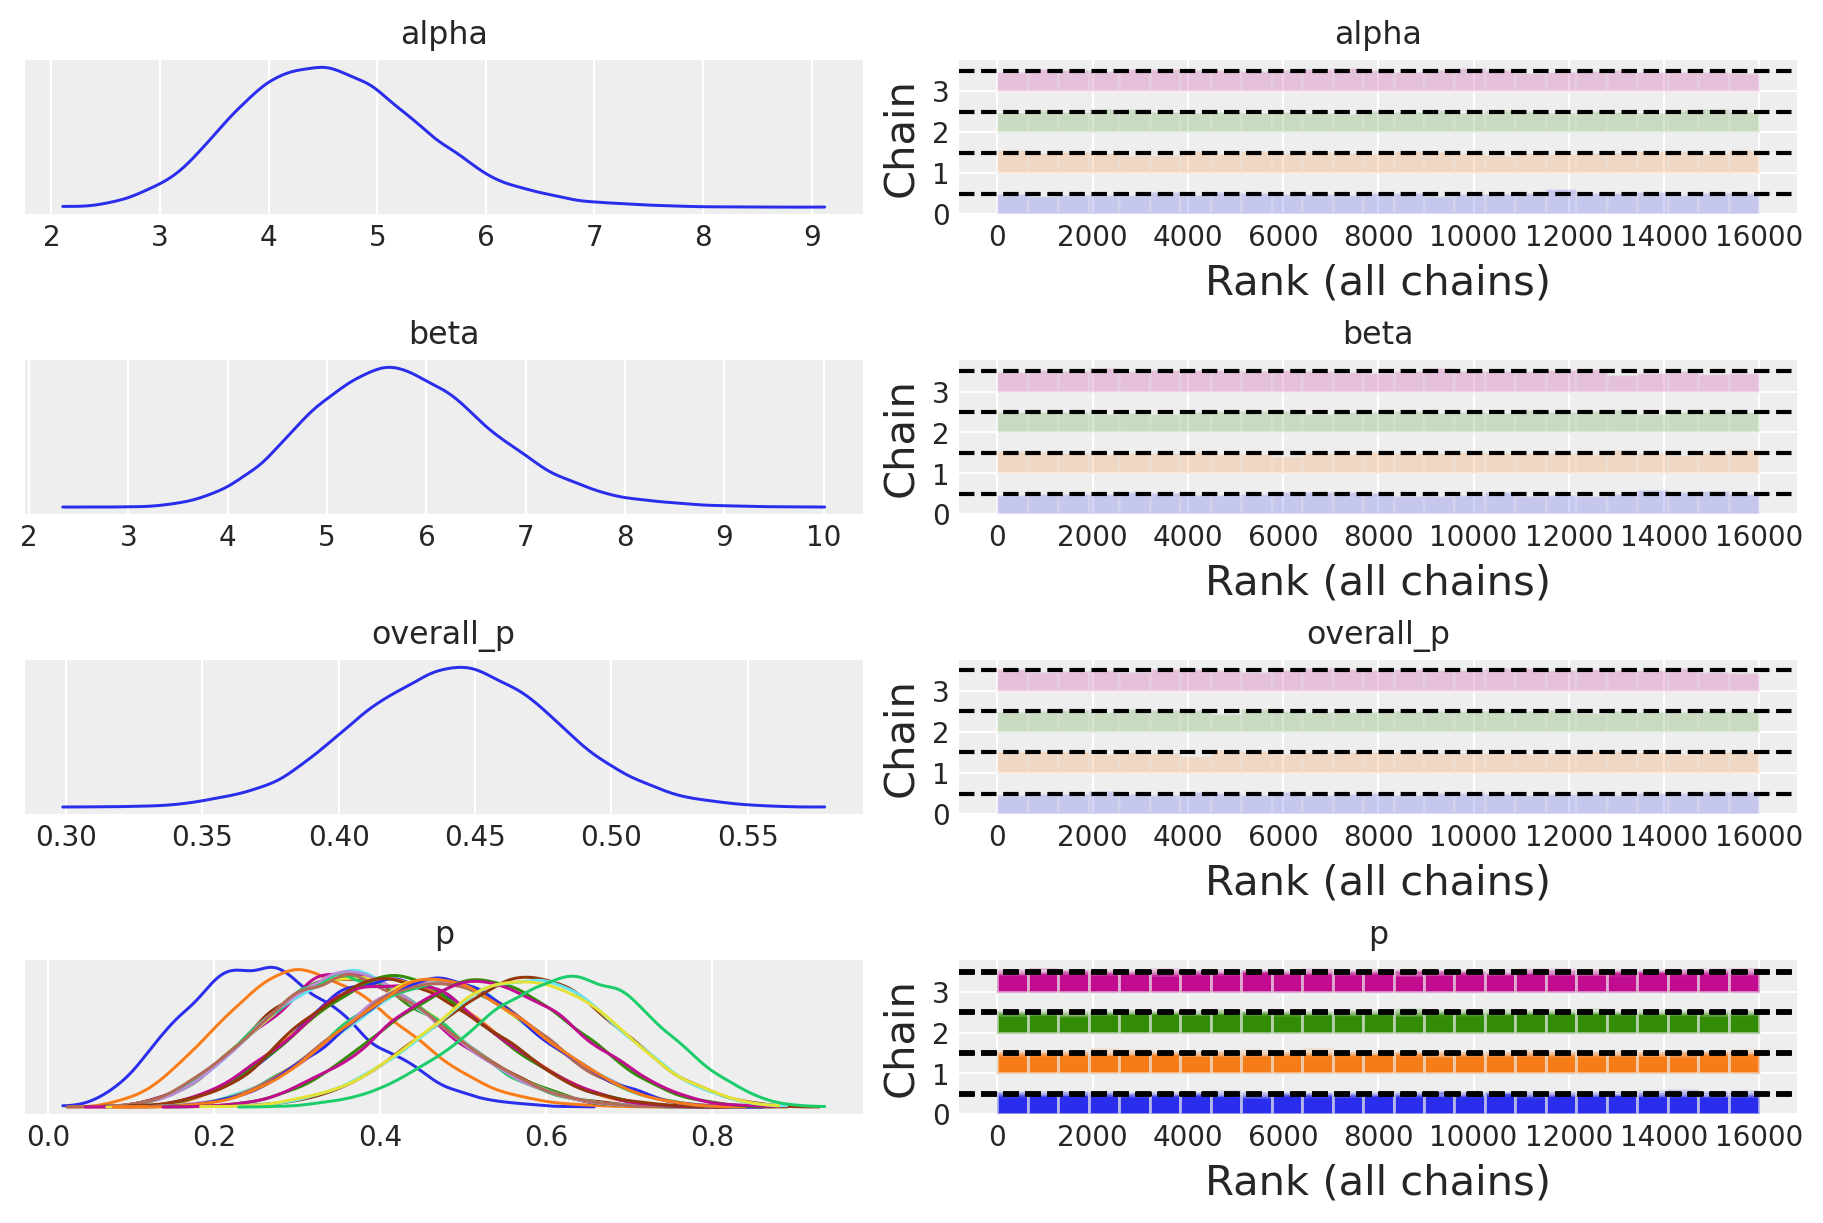

In [29]:
_ = az.plot_trace(idata, combined=True, figsize=(9, 6), kind="rank_bars")

Le distribuzioni posteriori degli iperparametri, prese da sole, non hanno un significato chiaro. Tuttavia, possiamo utilizzarle per calcolare la distribuzione a posteriori della probabilità di una risposta corretta per tutto il gruppo.

In [31]:
# Function to calculate the mean of a Beta distribution
def beta_mean(alpha, beta):
    return alpha / (alpha + beta)

# Calculate the means for each pair of alpha and beta
sample_posterior_x_means = np.array([beta_mean(a, b) for a, b in zip(alphas, betas)])

In [32]:
sample_posterior_x_means.shape

(4, 4000)

In [33]:
sample_posterior_x_means

array([[0.37604496, 0.41922669, 0.47345362, ..., 0.49569844, 0.47777766,
        0.4247707 ],
       [0.45096577, 0.41051049, 0.49462864, ..., 0.50996786, 0.53271226,
        0.4371311 ],
       [0.47134244, 0.47201767, 0.44473739, ..., 0.35595368, 0.41136842,
        0.46184053],
       [0.36027889, 0.42282699, 0.43706697, ..., 0.41162794, 0.43983373,
        0.46031791]])

In [34]:
print(sample_posterior_x_means.mean())

0.4428264916259948


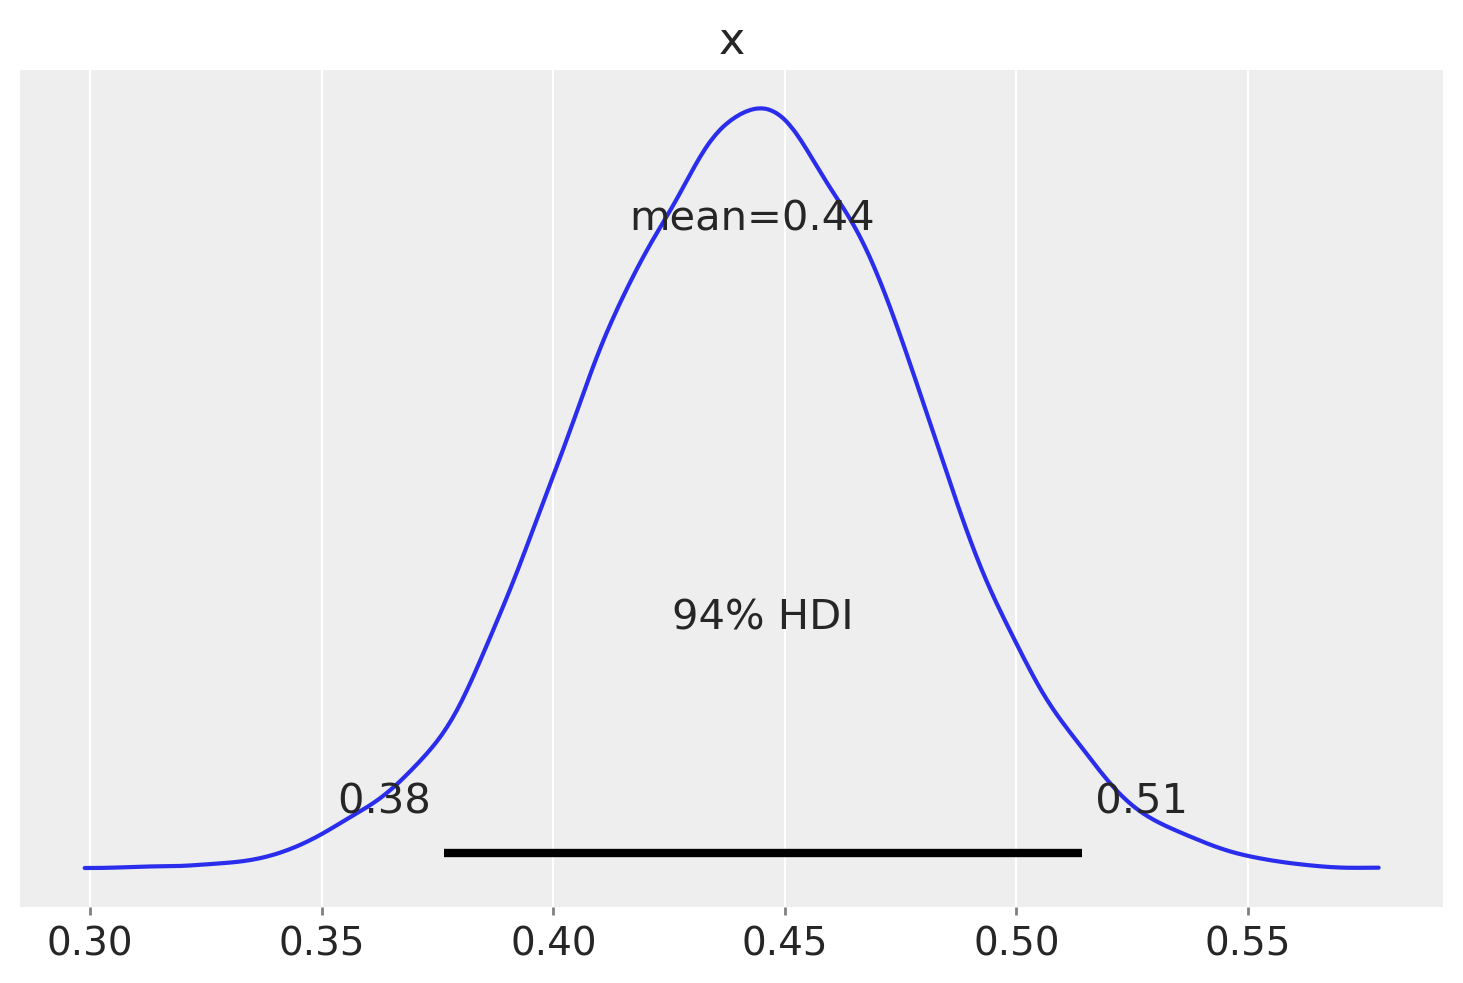

In [35]:
_ = az.plot_posterior(sample_posterior_x_means)

L'intervallo [0.37, 0.51] rappresenta l'intervallo di credibilità al 94% per la probabilità di risposta corretta `p`, considerando l'insieme del gruppo degli operatori. Questo intervallo ci fornisce un'indicazione sulla variabilità delle probabilità di successo tra gli operatori, considerando sia le differenze tra di loro che le somiglianze all'interno del gruppo.

Poiché l'intervallo di credibilità include il valore 0.5, possiamo concludere che non ci sono evidenze credibili che gli operatori, considerati nel loro insieme, siano in grado di "percepire il campo energetico di una persona senza vedere le mani" ad un livello diverso rispetto a quello che ci si potrebbe aspettare dal caso soltanto. 

### Considerazioni Conclusive

In questo capitolo, abbiamo introdotto l'approccio gerarchico bayesiano, un potente strumento per l'analisi di dati strutturati su più livelli. Per comprendere meglio la sua rilevanza e applicazione, consideriamo la seguente analogia.

Immaginiamo un'urna contenente palline blu e rosse. Stimare la proporzione di palline blu in un campione estratto da questa urna è un problema statistico elementare. Tuttavia, la realtà è spesso più complessa. Pensiamo invece a uno scenario più articolato: un'urna grande che contiene diverse urne più piccole, ognuna con la propria proporzione di palline blu e rosse. Questa situazione riflette meglio la complessità dei dati che incontriamo nel mondo reale.

In questo contesto più complesso, emergono due approcci estremi, entrambi insoddisfacenti. Da un lato, potremmo trattare ogni urna piccola come completamente indipendente dalle altre, ignorando il fatto che tutte provengono dalla stessa urna grande e sono quindi potenzialmente correlate. Dall'altro, potremmo concentrarci esclusivamente sull'urna grande, trascurando le peculiarità di ciascuna urna piccola. Entrambi questi approcci perdono informazioni cruciali sulla struttura dei dati.

È qui che l'approccio gerarchico bayesiano rivela la sua potenza. Esso ci permette di modellare simultaneamente sia le caratteristiche individuali delle urne piccole sia la loro relazione con l'urna grande che le contiene. In termini statistici, questo si traduce nella capacità di stimare non solo i parametri specifici di ogni gruppo (le urne piccole), ma anche i parametri che descrivono la distribuzione di questi gruppi nella popolazione più ampia (l'urna grande).

Nel corso del capitolo, abbiamo applicato questo concetto a un modello con verosimiglianza binomiale. Questo esempio ci ha permesso di illustrare come l'approccio gerarchico possa essere implementato per gestire dati organizzati su più livelli. Abbiamo visto come sia possibile stimare le probabilità di successo per ogni unità individuale (equivalente alle urne piccole nella nostra analogia), tenendo conto al contempo della distribuzione di queste probabilità nella popolazione generale (l'urna grande).

I vantaggi di questo approccio sono molteplici. In primo luogo, ci consente di effettuare stime più precise per ogni unità individuale, sfruttando l'informazione proveniente dall'intero dataset. Questo è particolarmente utile quando abbiamo poche osservazioni per alcune unità. In secondo luogo, ci permette di quantificare la variabilità tra le unità, fornendo preziose informazioni sulla struttura della popolazione. Infine, ci offre un framework naturale per fare previsioni su nuove unità non osservate, basandoci sulla distribuzione stimata a livello di popolazione.

L'approccio gerarchico bayesiano si rivela quindi uno strumento estremamente versatile e potente per affrontare problemi statistici complessi. Esso ci permette di modellare esplicitamente la struttura multilivello dei dati, migliorando la nostra comprensione delle relazioni intrinseche tra le variabili e fornendo inferenze più robuste e informative.

In conclusione, l'adozione di modelli gerarchici bayesiani apre nuove possibilità nell'analisi dei dati, permettendoci di affrontare con maggiore efficacia la complessità e la ricchezza delle informazioni presenti in molti domini psicologici. Mentre ci muoviamo verso analisi sempre più sofisticate, l'approccio gerarchico bayesiano si configura come un pilastro fondamentale nel toolkit del moderno analista di dati.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy 

Last updated: Sat Jul 27 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanpy: 1.2.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

arviz     : 0.18.0
pandas    : 2.2.2
matplotlib: 3.9.1
numpy     : 1.26.4
requests  : 2.32.3
cmdstanpy : 1.2.4
logging   : 0.5.1.2

Watermark: 2.4.3

